# Predicting sequences with LSTM

We will use a different type of network with a different structure, called **long short-term memory** (LSTM).


#### 1. Read some time series data

In [1]:
import pandas as pd
import numpy as np
orig_df = pd.read_csv("./data/series.csv", index_col='time')

In [2]:
print("First five rows")
orig_df.head()

First five rows


,value
time,
1/1/2015,10.227273
1/2/2015,10.876623
1/3/2015,11.525974
1/4/2015,14.772727
1/5/2015,19.318182


In [3]:
print("Last five rows")
orig_df.tail()

Last five rows


,value
time,
8/24/2015,88.149351
8/25/2015,88.149351
8/26/2015,88.149351
8/27/2015,88.149351
8/28/2015,88.149351


In [4]:
print("Time series value")
orig_df.plot()

Time series value


In [5]:
print("Make a copy of orig_df into df using the .copy() method")
df = orig_df.copy()

Make a copy of orig_df into df using the .copy() method


#### 2. Baseline model for time series prediction

Let's set up a simple benchmark. We will forecast, at the beginning of the month, that the value will be the value from the previous month.

In [6]:
# Baseline prediction: at the beginning of the month, predict the value of the previous month
df['Baseline Prediction'] = df.shift(1)

In [7]:
print("First five rows")
df.head()

First five rows


,value,Baseline Prediction
time,,
1/1/2015,10.227273,NaN
1/2/2015,10.876623,10.227273
1/3/2015,11.525974,10.876623
1/4/2015,14.772727,11.525974
1/5/2015,19.318182,14.772727


In [8]:
print("Preprocessing step: Replace the nan value by 10.22")
from sklearn.metrics import mean_squared_error
df.fillna(value=10.22,axis=0, inplace=True)

Preprocessing step: Replace the nan value by 10.22


**Mean squared error of our baseline and see how it looks**

In [9]:
print("Mean squared error of the baseline model")
mean_squared_error(df['value'],df['Baseline Prediction'])

Mean squared error of the baseline model


0.5639654757658225

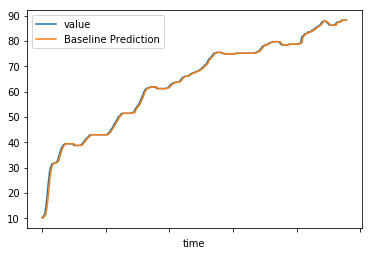

In [10]:
df.plot()

In [11]:
df['y'] = df['value'].shift(-1)

In [12]:
df.drop('Baseline Prediction', axis=1, inplace=True)

#### 3. Preprocessing

Time series data usually has some trend, and this might make things difficult to predict. 

One way of dealing with trends is to take differences instead. 

We will also normalize the values so that everything stays between -1 and 1.


In [13]:
print("Use the .diff() method to take differences automatically")
df.diff().head()

Use the .diff() method to take differences automatically


,value,y
time,,
1/1/2015,NaN,NaN
1/2/2015,0.649351,0.649351
1/3/2015,0.649351,3.246753
1/4/2015,3.246753,4.545455
1/5/2015,4.545455,5.194805


In [14]:
df.diff().tail()

,value,y
time,,
8/24/2015,0.649351,0.0
8/25/2015,0.000000,0.0
8/26/2015,0.000000,0.0
8/27/2015,0.000000,0.0
8/28/2015,0.000000,NaN


In [15]:
df = df.diff()

In [16]:
df.fillna(value=df['y'].mean(),axis=0, inplace=True)

In [17]:
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler(feature_range=(-1,1))

#### 4. Dividing between training and testing.

As the information is coming sequentially, it makes more sense to split between training and validation in the natural order it happens.

In [18]:
train_idx = int(0.8*len(df))
train, test = df.values[0:-train_idx], df.values[-train_idx:]

In [19]:
train = scl.fit_transform(train)
test = scl.transform(test)

In [20]:
X_train, y_train = train[:,0:-1], train[:,-1]
X_test, y_test = test[:,0:-1], test[:,-1]

The LSTM layer expects input as 
- **samples**: independent observations.
- **timesteps**: the same sample measured during different time steps. Here we have 1 sample = 1 time step.
- **features**: the usual attributes.


In [21]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [22]:
batch_size = 1
n_epochs = 100
neurons = 4

In [23]:
from keras.models import Sequential
from keras.layers import LSTM,Dense
model = Sequential()
model.add(
    LSTM(neurons, 
               batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]), stateful=True)
         )
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

C:\Users\pc\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [24]:
model.fit(X_train,y_train, epochs=n_epochs, batch_size=batch_size, verbose=0)

In [25]:
preds = model.predict(X_test, batch_size=batch_size)

In [26]:
reshaped_preds = np.concatenate([X_test.reshape(X_test.shape[0],1),preds], axis=1)

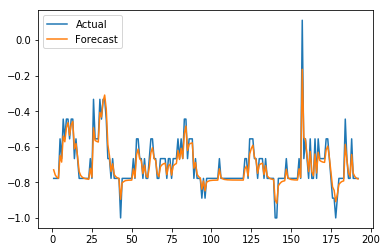

In [27]:
pd.DataFrame(data = reshaped_preds, columns = ['Actual','Forecast'], 
             index=range(1,train_idx+1)).plot()

In [30]:
mean_squared_error(reshaped_preds[:,0], reshaped_preds[:,1])

0.0020044959899760332

In [31]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')